In [1]:
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

#### There was a problem in the original header_columns so modified it according to the data

In [2]:
header_columns = 'Author_ID|Author_name|Comment_number|Sentence_number|Domain_Relevance|Sentiment|Entity|Attribute|Sentence|Source_file|Annotator|Aspect'.split('|')
domain_relevance_classes = ['0', '9']
entity_classes = ['g', 'p', 'f', 'c', 'cg', 'cp', 'cf', 'cc', 'gg']
attribute_classes = ['g', 'p', 't', 'q', 's', 'h', 'c', 'll', 'or', 'l', 'av', 'e', 'a', 'pp']
sentiment_classes = ['p', 'n', '0']

od_entity_mapping = {
	'g': 'organic general',
	'p': 'organic products',
	'f': 'organic farmers',
	'c': 'organic companies',
	'cg': 'conventional general',
	'cp': 'conventional products',
	'cf': 'conventional farming',
	'cc': 'conventional companies',
	'gg': 'GMOs genetic engineering general'
}
od_attribute_mapping = {
	'g': 'general',
	'p': 'price',
	't': 'taste',
	'q': 'Nutr. quality & freshness',
	's': 'safety',
	'h': 'healthiness',
	'c': 'chemicals pesticides',
	'll': 'label',
	'or': 'origin source',
	'l': 'local',
	'e': 'environment',
	'av': 'availability',
	'a': 'animal welfare',
	'pp': 'productivity'
}
od_sentiment_mapping = {
	'0': 'neutral',
	'p': 'positive',
	'n': 'negative'
}
od_coarse_entities = {
	'g': 'organic',
	'p': 'organic',
	'f': 'organic',
	'c': 'organic',
	'cg': 'conventional',
	'cp': 'conventional',
	'cf': 'conventional',
	'cc': 'conventional',
	'gg': 'GMO'
}
od_coarse_attributes = {
	'g': 'general',
	'p': 'price',
	't': 'experienced quality',
	'q': 'experienced quality',
	's': 'safety and healthiness',
	'h': 'safety and healthiness',
	'c': 'safety and healthiness',
	'll': 'trustworthy sources',
	'or': 'trustworthy sources',
	'l': 'trustworthy sources',
	'av': 'trustworthy sources',
	'e': 'environment',
	'a': 'environment',
	'pp': 'environment',
}


# Investigation of V02 Annotated Dataset

Load train, test and validation datasets

In [3]:
file_train = glob('./train_test_validation V0.2/train/dataframe.csv')
dfTrain = pd.read_csv(file_train[0],sep='|',names=header_columns,header=0)

file_val = glob('./train_test_validation V0.2/validation/dataframe.csv')
dfVal = pd.read_csv(file_val[0],sep='|',names=header_columns,header=0)

file_test = glob('./train_test_validation V0.2/test/dataframe.csv')
dfTest = pd.read_csv(file_test[0],sep='|',names=header_columns,header=0)

In [4]:
frames = [dfTrain, dfVal, dfTest]
dfAll = pd.concat(frames)

In [5]:
dfAll.head(10)

,Author_ID,Author_name,Comment_number,Sentence_number,Domain_Relevance,Sentiment,Entity,Attribute,Sentence,Source_file,Annotator,Aspect
0,Justin-Ma,Justin Ma,521,1,0,NaN,NaN,NaN,Thanks for the thoughtful response.,quora.json,sumit,nan-nan
1,Justin-Ma,Justin Ma,521,2,0,NaN,NaN,NaN,I think we actually have a lot of common groun...,quora.json,sumit,nan-nan
2,Justin-Ma,Justin Ma,521,3,0,NaN,NaN,NaN,All I want to emphasize are my main points: Pr...,quora.json,sumit,nan-nan
3,Justin-Ma,Justin Ma,521,4,9,p,cg,pp,Industrialization is everything about producti...,quora.json,sumit,cg-pp
4,Justin-Ma,Justin Ma,521,5,0,NaN,NaN,NaN,Creating jobs at the expense of efficiency is ...,quora.json,sumit,nan-nan
5,Justin-Ma,Justin Ma,521,6,0,NaN,NaN,NaN,The externalities associated with industrializ...,quora.json,sumit,nan-nan
6,Justin-Ma,Justin Ma,521,7,9,0,g,g,'Organic' agriculture goes along with that the...,quora.json,sumit,g-g
7,Justin-Ma,Justin Ma,521,8,0,NaN,NaN,NaN,Agriculture was pretty destructive from the 19...,quora.json,sumit,nan-nan
8,Justin-Ma,Justin Ma,521,9,0,NaN,NaN,NaN,There's been steady 'sustainable' improvements...,quora.json,sumit,nan-nan
9,Justin-Ma,Justin Ma,521,10,0,NaN,NaN,NaN,This happened before organic took off.,quora.json,sumit,nan-nan


In [6]:
print(dfAll.shape)

(10441, 12)


In [7]:
print(dfAll.Domain_Relevance.value_counts())

9    5561
0    4880
Name: Domain_Relevance, dtype: int64


In [8]:
def verify_labels(df,
                  domain_relevance_classes=domain_relevance_classes,
                  sentiment_classes=sentiment_classes,
                  entity_classes=entity_classes,
                  attribute_classes=attribute_classes):
    
    
    # impute nans and cast to int
    df.Domain_Relevance.astype(str, inplace=True)
    df.Domain_Relevance.fillna('0', inplace=True)
    df.loc[df.Domain_Relevance.apply(lambda x: x not in ['9', '9.0', '0', '0.0']), 'Domain_Relevance'] = '9'
    df.Domain_Relevance = df.Domain_Relevance.astype(np.int8)
    
    # verfiy domain relevance
    dr_check = np.sum(df.Domain_Relevance.astype(str).str.strip().apply(lambda x: x in domain_relevance_classes))/df.shape[0]

    # verify sentiment 
    dr_df = df[df.Domain_Relevance == 9]
    sent_check = np.sum(dr_df.Sentiment.str.strip().apply(lambda x: x in sentiment_classes))/dr_df.shape[0]
    
    # verify entity
    entity_check = np.sum(dr_df.Entity.str.strip().apply(lambda x: x in entity_classes))/dr_df.shape[0]
    
    # verify attribute
    attrib_check = np.sum(dr_df.Attribute.str.strip().apply(lambda x: x in attribute_classes))/dr_df.shape[0]
    
    if (dr_check and sent_check and entity_check and attrib_check):
        df['Aspect'] = df.Entity.str.strip() + '-' + df.Attribute.str.strip()
        return True
    print(str(dr_check) + ' ' + str(sent_check) + ' ' + str(entity_check) + ' ' + str(attrib_check))
    return False

In [9]:
print(verify_labels(dfAll.copy())) # Copy because the function modifies the original df

True


In [10]:
plt.rcParams["figure.figsize"] = [8, 12]

In [11]:
def domain_relevance_distribution(df):
    # domain relevance
    domain_relevant_sentence_count = df.Domain_Relevance.value_counts()[9]
    domain_irrelevant_sentence_count = df.Domain_Relevance.value_counts()[0]
    total_sentence_count = domain_relevant_sentence_count + domain_irrelevant_sentence_count
    domain_relevant_ratio = domain_relevant_sentence_count/total_sentence_count
    domain_irrelevant_ratio = domain_irrelevant_sentence_count/total_sentence_count
    labels = ['Domain-Relevant', 'Domain-Irrelevant']
    sizes = [domain_relevant_ratio, domain_irrelevant_ratio]
    colors = ['yellowgreen', 'gold']
    figure = plt.figure()
    patches, texts, _ = plt.pie(sizes, colors=colors, shadow=True, startangle=90, autopct='%1.1f%%')
    plt.legend(patches, labels, loc="best")
    plt.axis('equal')
    plt.tight_layout()
    plt.title('Relevance Distribution')
    plt.show()
    return figure

In [12]:
def sentiment_distribution(df):
    # sentiment distribution
    neutral_sentiment_count = df.Sentiment.str.strip().value_counts()['0']
    positive_sentiment_count = df.Sentiment.str.strip().value_counts()['p']
    negative_sentiment_count = df.Sentiment.str.strip().value_counts()['n']
    total_sentence_count = neutral_sentiment_count + positive_sentiment_count + negative_sentiment_count
    neutral_ratio = neutral_sentiment_count/total_sentence_count
    positive_ratio = positive_sentiment_count/total_sentence_count
    negative_ratio = negative_sentiment_count/total_sentence_count
    
    figure = plt.figure()
    
    labels = ['Neutral', 'Positive', 'Negative']
    sizes = [neutral_ratio, positive_ratio, negative_ratio]
    colors = ['yellowgreen', 'gold', 'lightskyblue']
    patches, texts,_ = plt.pie(sizes, colors=colors, shadow=True, startangle=90, autopct='%1.1f%%')
    plt.legend(patches, labels, loc="best")
    plt.axis('equal')
    plt.tight_layout()
    plt.title('Sentiment Distribution')
    plt.show()
    
    return figure

# sentiment_distribution(df)

In [13]:
def entity_distribution(df):
    # entity distribution
    p_count = df.Entity.str.strip().value_counts()['p'] if 'p' in df.Entity.str.strip().value_counts() else 0
    f_count = df.Entity.str.strip().value_counts()['f'] if 'f' in df.Entity.str.strip().value_counts() else 0
    g_count = df.Entity.str.strip().value_counts()['g'] if 'g' in df.Entity.str.strip().value_counts() else 0
    c_count = df.Entity.str.strip().value_counts()['c'] if 'c' in df.Entity.str.strip().value_counts() else 0
    cp_count = df.Entity.str.strip().value_counts()['cp'] if 'cp' in df.Entity.str.strip().value_counts() else 0
    cf_count = df.Entity.str.strip().value_counts()['cf'] if 'cf' in df.Entity.str.strip().value_counts() else 0
    cg_count = df.Entity.str.strip().value_counts()['cg'] if 'cg' in df.Entity.str.strip().value_counts() else 0
    cc_count = df.Entity.str.strip().value_counts()['cc'] if 'cc' in df.Entity.str.strip().value_counts() else 0
    gg_count = df.Entity.str.strip().value_counts()['gg'] if 'gg' in df.Entity.str.strip().value_counts() else 0
    total = np.sum(df.Entity.str.strip().value_counts())
    p_ratio = p_count/total
    f_ratio = f_count/total
    g_ratio = g_count/total
    c_ratio = c_count/total
    cp_ratio = cp_count/total
    cf_ratio = cf_count/total
    cg_ratio = cg_count/total
    cc_ratio = cc_count/total
    gg_ratio = gg_count/total
    
    figure = plt.figure()
    
    labels = [od_entity_mapping['p'], od_entity_mapping['f'], od_entity_mapping['g'],od_entity_mapping['c'],od_entity_mapping['cp'],od_entity_mapping['cf'],od_entity_mapping['cg'],od_entity_mapping['cc'],od_entity_mapping['gg']]
    colors = ['yellowgreen', 'gold', 'lightskyblue', 'red', 'blue', 'pink', 'white', 'green', 'orange']
    sizes = [p_ratio, f_ratio, g_ratio, c_ratio, cp_ratio, cf_ratio, cg_ratio, cc_ratio, gg_ratio]
    patches, texts,_ = plt.pie(sizes, shadow=True, startangle=90, autopct='%1.1f%%', colors=colors)
    plt.legend(patches, labels, loc='best')
    plt.axis('equal')
    plt.tight_layout()
    plt.title('Entity Distribution')
    plt.show()
    
    return figure
    
# entity_distribution(df)

In [14]:
def attribute_distribution(df):
    # attribute distribution
    g = df.Attribute.str.strip().value_counts()['g'] if 'g' in df.Attribute.str.strip().value_counts() else 0
    p = df.Attribute.str.strip().value_counts()['p'] if 'p' in df.Attribute.str.strip().value_counts() else 0
    ll = df.Attribute.str.strip().value_counts()['ll'] if 'll' in df.Attribute.str.strip().value_counts() else 0
    h = df.Attribute.str.strip().value_counts()['h'] if 'h' in df.Attribute.str.strip().value_counts() else 0
    e = df.Attribute.str.strip().value_counts()['e'] if 'e' in df.Attribute.str.strip().value_counts() else 0
    c = df.Attribute.str.strip().value_counts()['c'] if 'c' in df.Attribute.str.strip().value_counts() else 0
    s = df.Attribute.str.strip().value_counts()['s'] if 's' in df.Attribute.str.strip().value_counts() else 0
    q = df.Attribute.str.strip().value_counts()['q'] if 'q' in df.Attribute.str.strip().value_counts() else 0
    pp = df.Attribute.str.strip().value_counts()['pp'] if 'pp' in df.Attribute.str.strip().value_counts() else 0
    t = df.Attribute.str.strip().value_counts()['t'] if 't' in df.Attribute.str.strip().value_counts() else 0
    _or = df.Attribute.str.strip().value_counts()['_or'] if '_or' in df.Attribute.str.strip().value_counts() else 0
    a = df.Attribute.str.strip().value_counts()['a'] if 'a' in df.Attribute.str.strip().value_counts() else 0
    l = df.Attribute.str.strip().value_counts()['l'] if 'l' in df.Attribute.str.strip().value_counts() else 0
    av = df.Attribute.str.strip().value_counts()['av'] if 'av' in df.Attribute.str.strip().value_counts() else 0
    
    figure = plt.figure()
    
    label = ['General(g)', 'Price(p)', 'Label(ll)', 'Healthiness(h)', 'Environment(e)', 'Chemicals/Pesticides(c)', 
             'Safety(s)', 'Quality/Freshness(q)','Productivity(pp)', 'Taste(t)', 'Organic Source(or)', 
             'Animal Welfare(a)', 'Local(l)', 'Availability(av)']
    counts = [g,p,ll,h,e,c,s,q,pp,t,_or,a,l,av]
    index = np.arange(len(label))
    plt.barh(index, counts, color='green', align='center')
    plt.ylabel('Attributes', fontsize=10, )
    plt.xlabel('No of Sentences', fontsize=10)
    plt.yticks(index, label, fontsize=7, rotation=0)
    plt.title('Attribute Distribution')
    plt.show()
    
    return figure
    
# attribute_distribution(df)

In [15]:
# df.Aspect.str.strip().value_counts()
def draw_aspect_distribution(aspects, counts, entity):
    # attribute distribution
    figure = plt.figure()
    index = np.arange(len(aspects))
    plt.barh(index, counts, color='blue', align='center')
    plt.ylabel('Aspects', fontsize=10, )
    plt.xlabel('No of Sentences', fontsize=10)
    plt.yticks(index, aspects, fontsize=10, rotation=0)
    plt.title('Aspect Distribution for entity : '+ entity + ' : ' + od_entity_mapping[entity])
    plt.show()
    return figure

def aspect_distribution(df):
    entities = ['g', 'p', 'f', 'c', 'cg', 'cp', 'cf', 'cc', 'cg', 'gg']
    attributes = ['g', 'p', 'll', 'h', 'e', 'c', 's', 'q', 'pp', 't', 'or', 'a', 'l', 'av']
    
    figures = []
    for idx,e in enumerate(entities):
        aspects = []
        counts = []
        for a in attributes:
            aspects.append(e+'-'+a)
            c = df.Aspect.str.strip().value_counts()[aspects[-1]] if aspects[-1] in df.Aspect.str.strip().value_counts() else 0
            counts.append(c)
        
        figures.append(draw_aspect_distribution(aspects, counts, e))
    
    return figures

    
# aspect_distribution(df)

In [16]:
# comments with 0 relevant sentences
def get_unrelevant_comment_ids(df):
    dr_grp = df.groupby(['Comment_number']).mean()
    return dr_grp[dr_grp.Domain_Relevance == 0.0].index.values

# comments with > 0 relevant sentences
def get_relevant_comment_ids(df):
    dr_grp = df.groupby(['Comment_number']).mean()
    return dr_grp[dr_grp.Domain_Relevance > 0.0].index.values

# This method gives disttribution of sentiments over a dataframe
def get_sentiment_distribution(df):
    sent_counts = df.Sentiment.str.strip().value_counts()
    k = sent_counts.keys()
    sentiment_distrbution = {
        k[0] : sent_counts[k[0]],
        k[1] : sent_counts[k[1]],
        k[2] : sent_counts[k[2]]
    }
    return sentiment_distrbution

# This method fetches dataframe ids for a given comment id and a given dataframe object
def get_dataframe_ids_for_comment_id(df, comment_id):
    return df.groupby(['Comment_number']).groups[comment_id]

In [17]:
# This method generates an aspect-vs-comment-id map from a dataframe
def get_aspect_comment_ids_map(df):
    keys = get_aspect_keys(df)
    aspect_comment_ids_map = {}
    for k in keys:
        v = list(df.iloc[df.groupby(['Aspect']).groups[k]].groupby(['Comment_number']).groups.keys())
        aspect_comment_ids_map[k] = v
    return aspect_comment_ids_map

# This method generates a sorted aspect, comment-count tuple list
def get_aspect_comment_count(df, aspect_comment_ids_map):
    keys = get_aspect_keys(df)
    aspect_comment_count_map = {}
    for k in keys:
        v = len(aspect_comment_ids_map.get(k))
        aspect_comment_count_map[k] = v
    aspect_comment_count_map = sorted(aspect_comment_count_map.items(), key=lambda kv: kv[1])
    return aspect_comment_count_map

# This method returns a list of aspect keys
def get_aspect_keys(df):
    return df.Aspect.str.strip().value_counts().keys()

def generate_data_stats(df,isPrinting=False):
    plot1 = domain_relevance_distribution(df)
    plot2 = sentiment_distribution(df)
    plot3 = entity_distribution(df)
    plot4 = attribute_distribution(df)
    plots = aspect_distribution(df)
    
    if (isPrinting):
        pp = PdfPages('out.pdf')
        pp.savefig(plot1)
        pp.savefig(plot2)
        pp.savefig(plot3)
        pp.savefig(plot4)
        for plot in plots:
            pp.savefig(plot)
        pp.close()

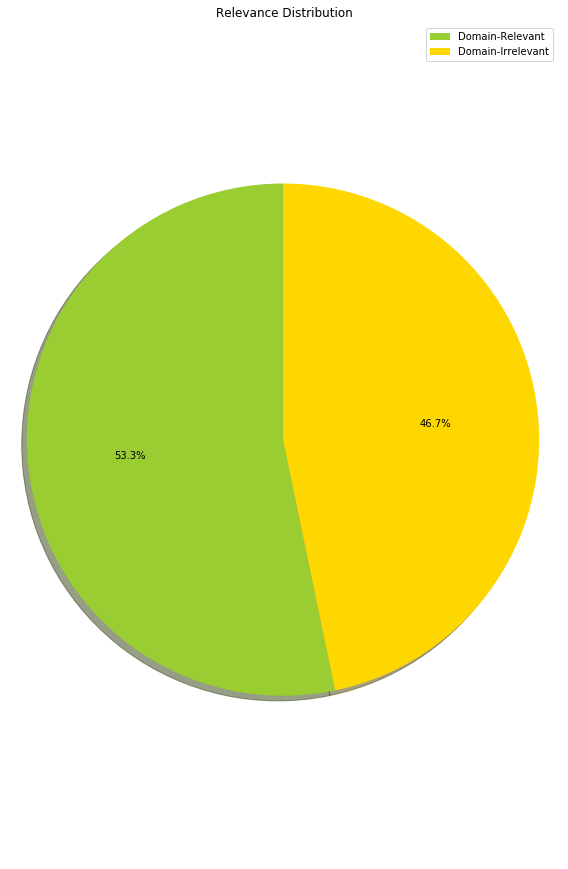

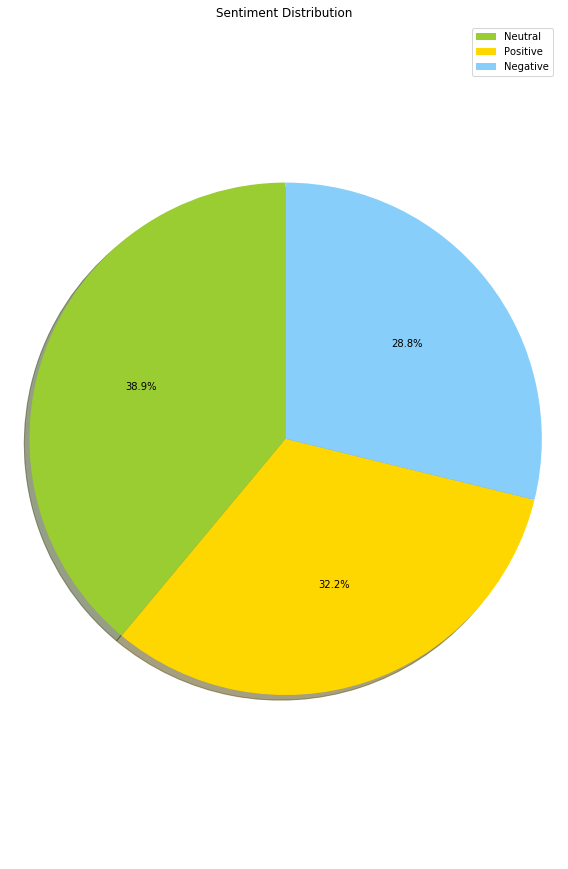

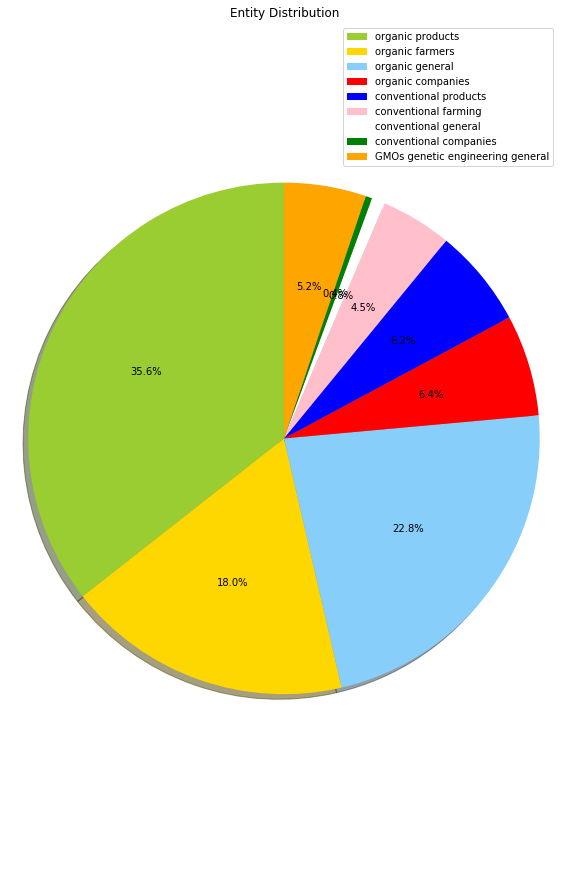

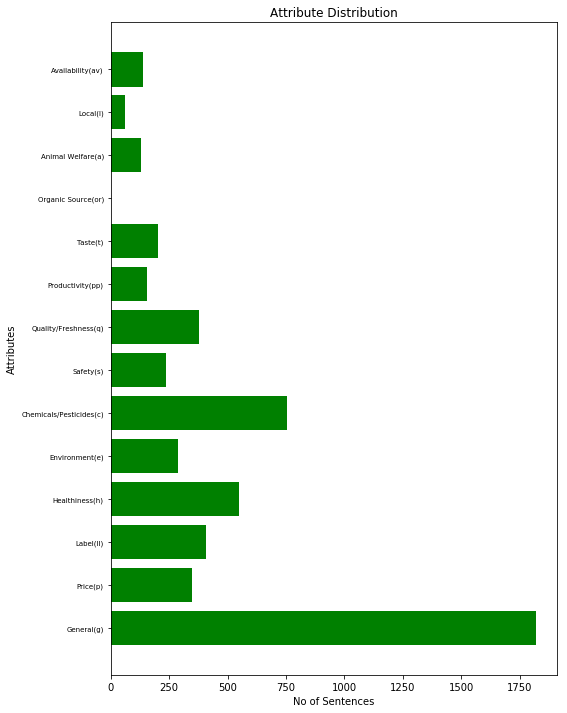

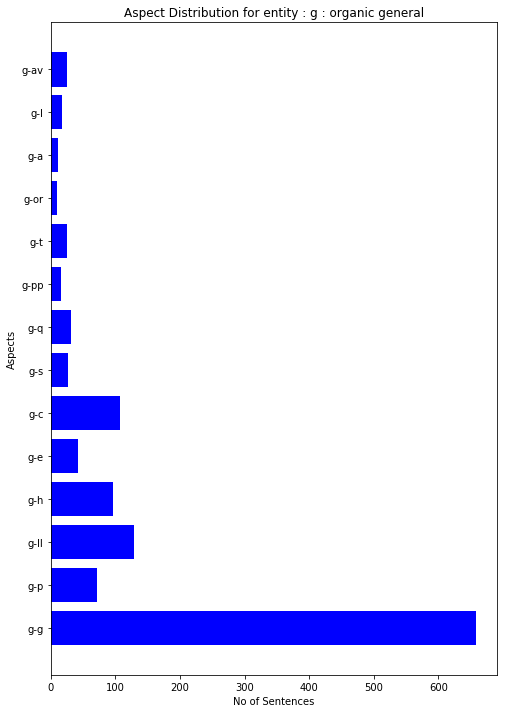

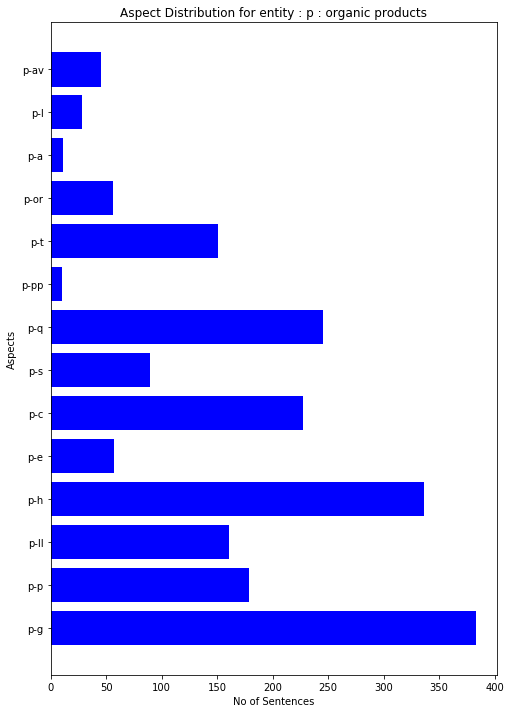

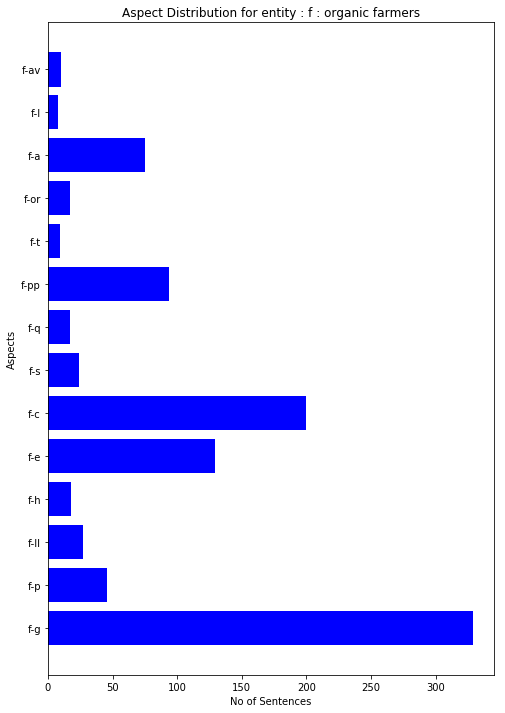

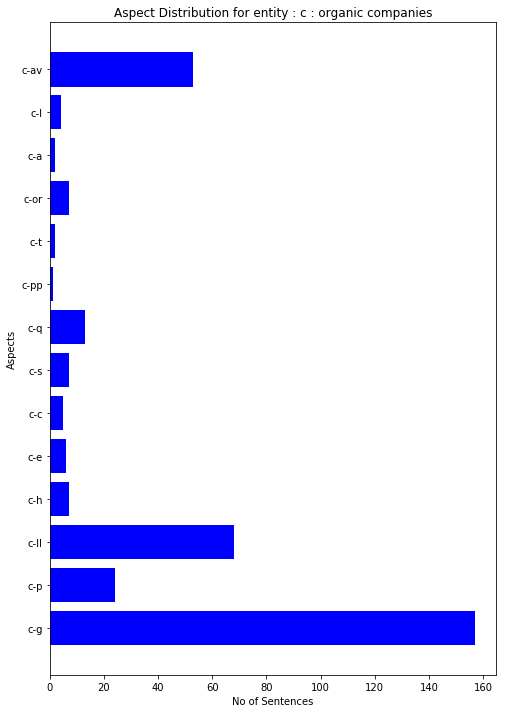

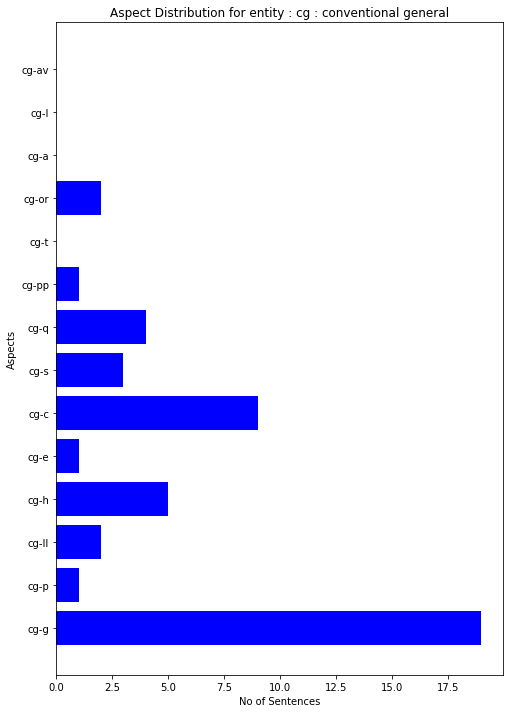

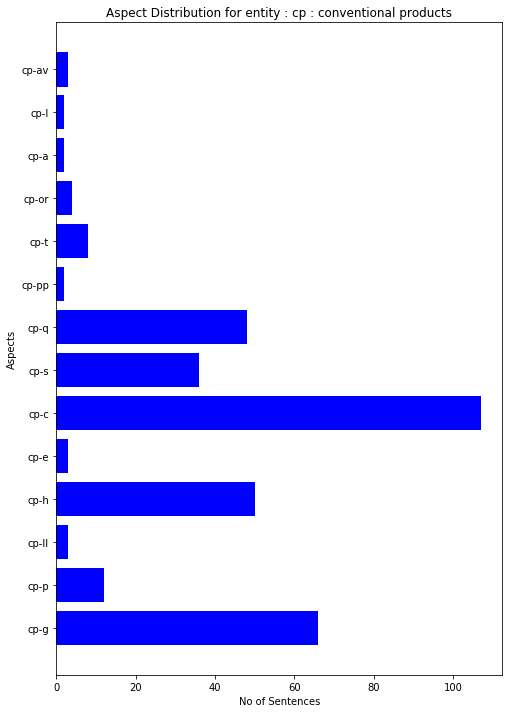

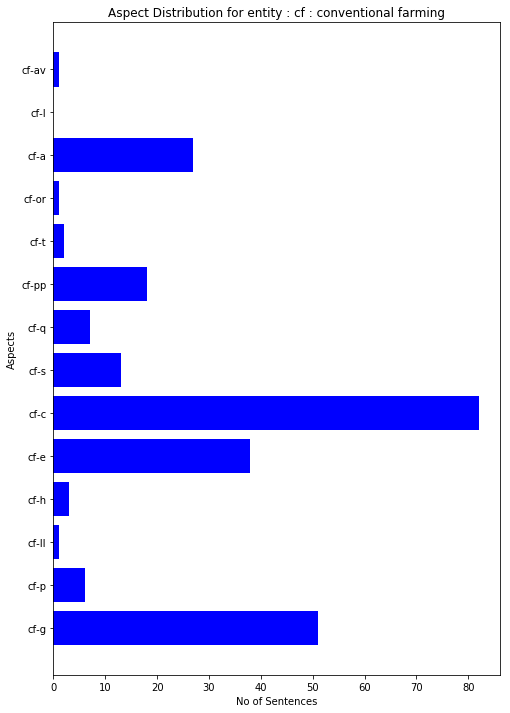

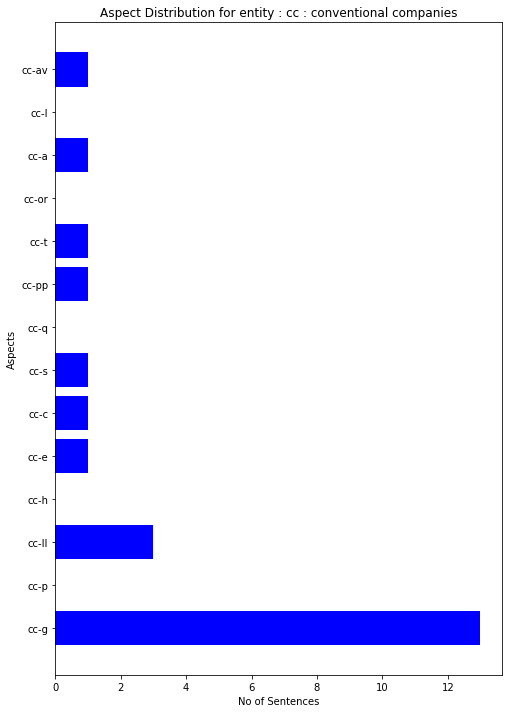

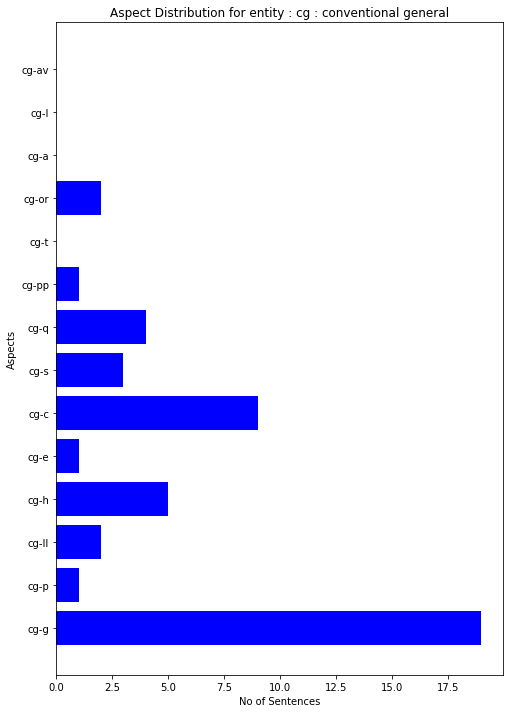

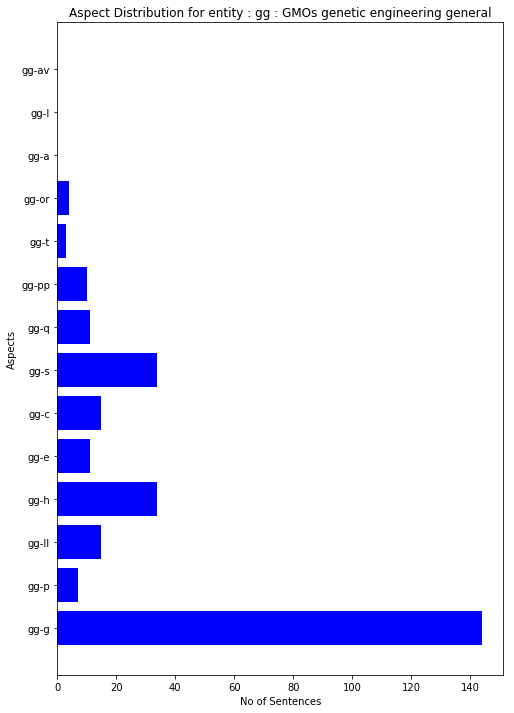

In [18]:
# Combined Data stats
generate_data_stats(dfAll)

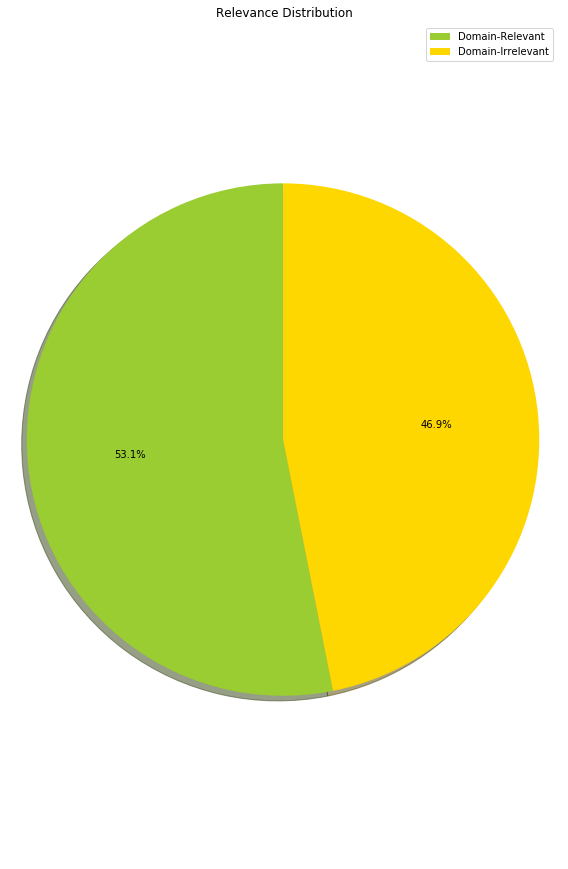

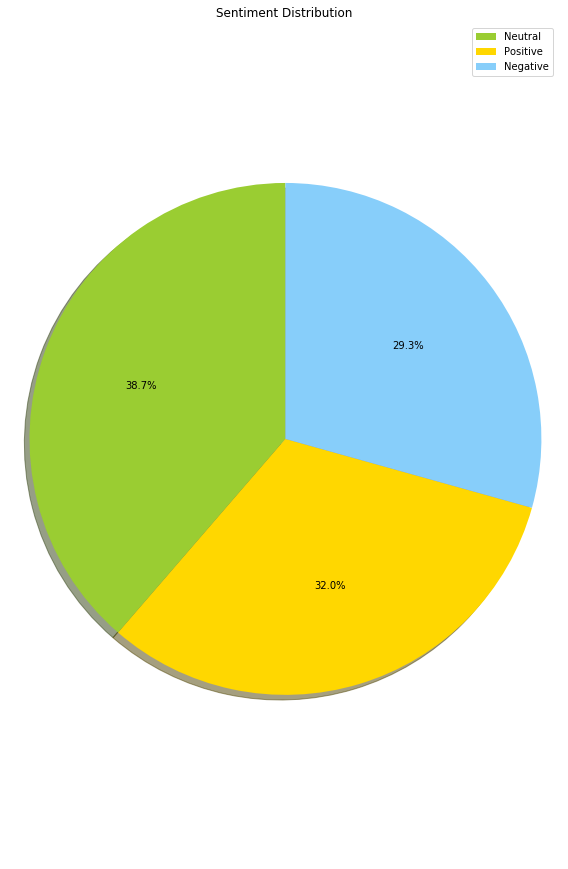

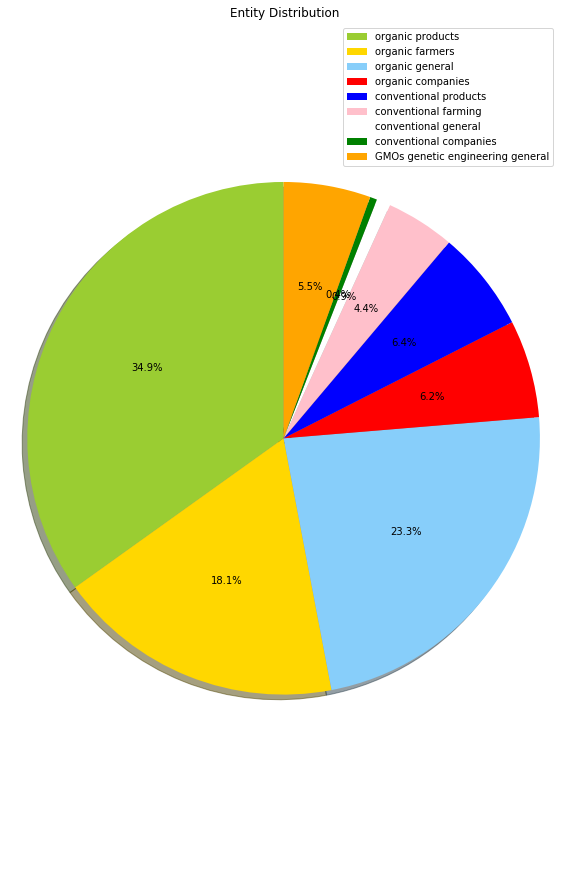

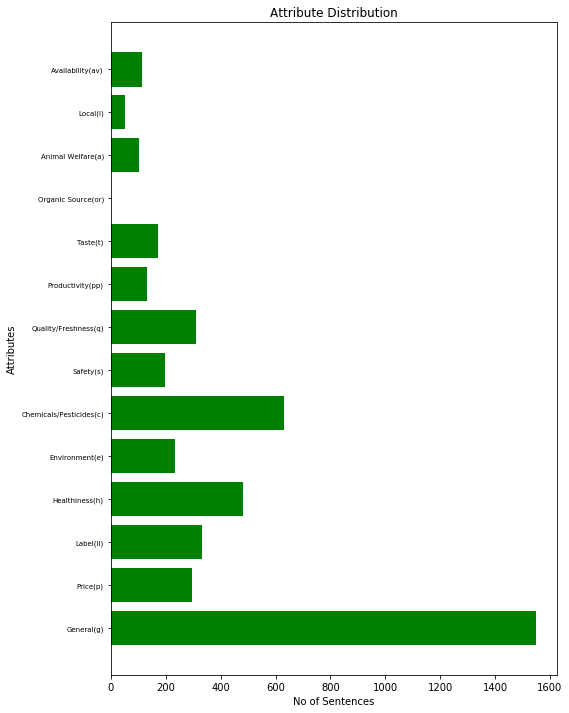

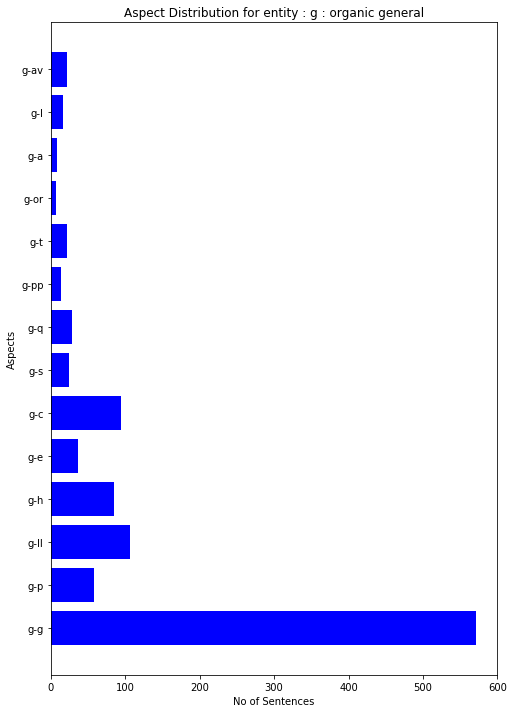

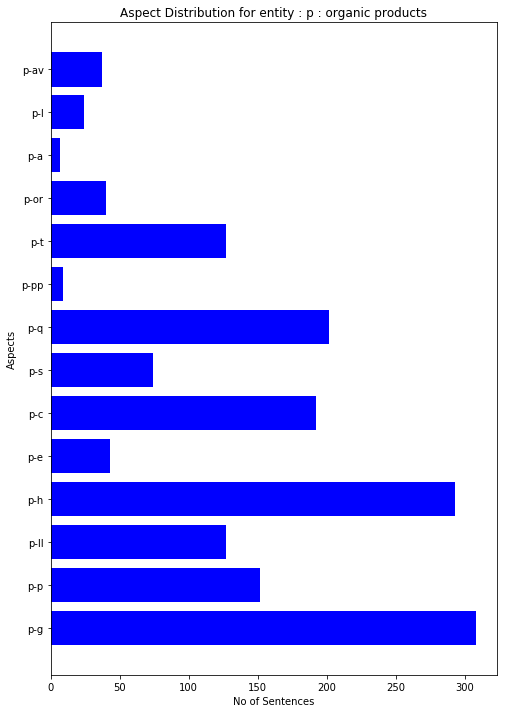

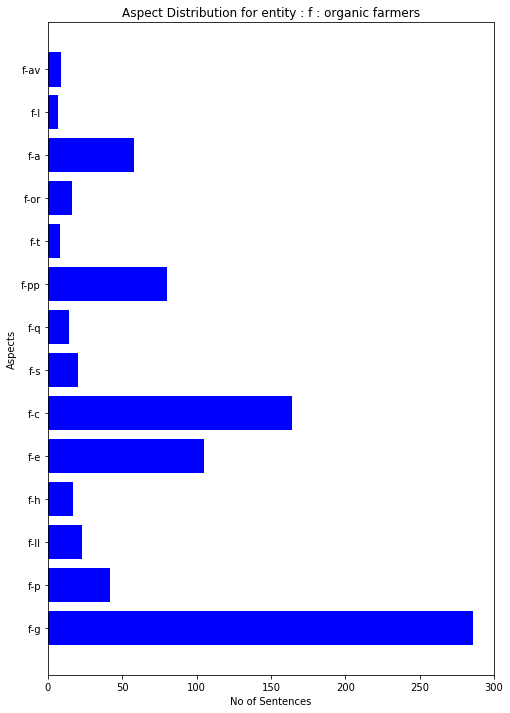

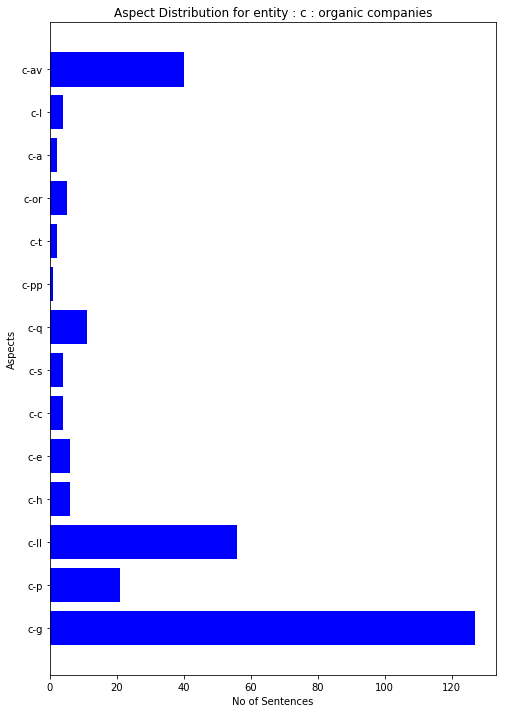

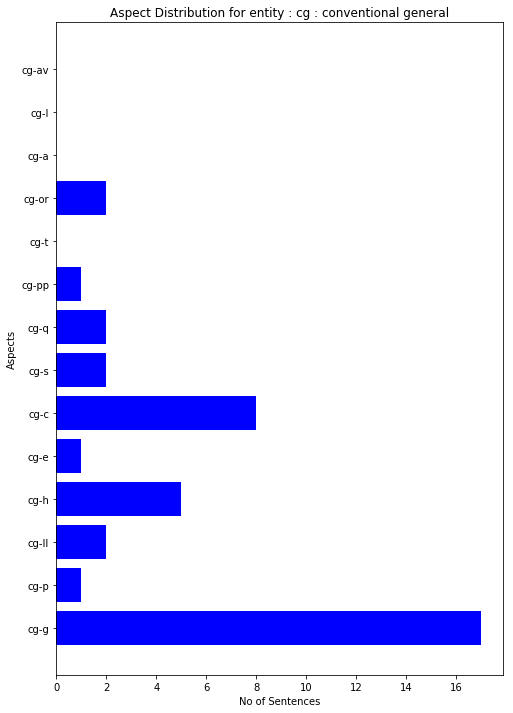

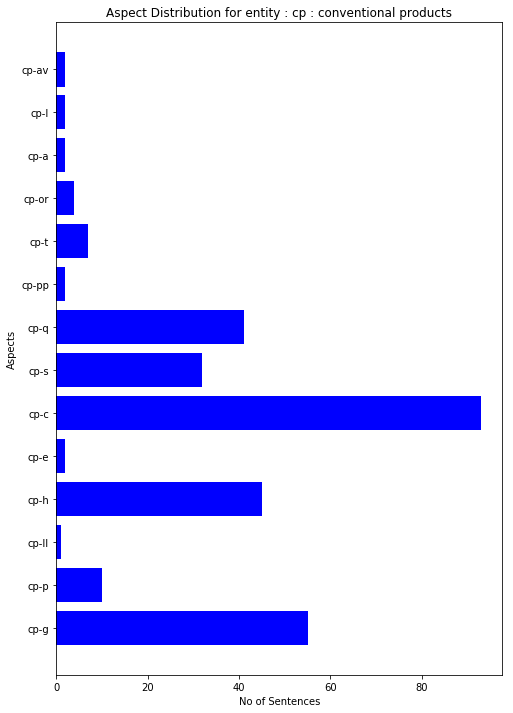

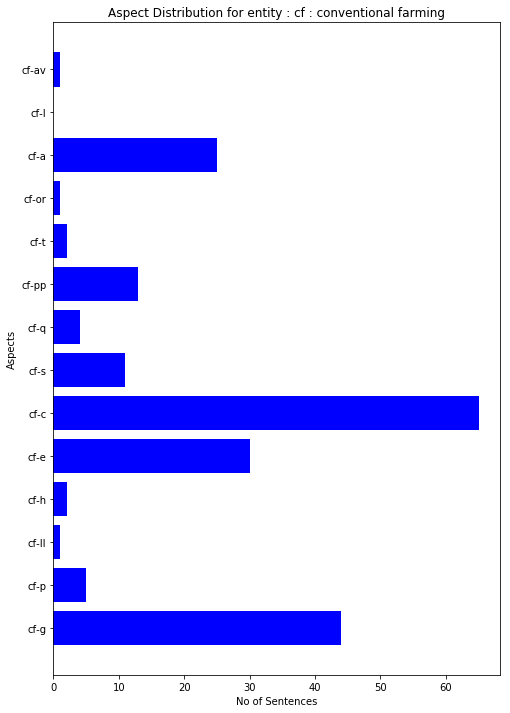

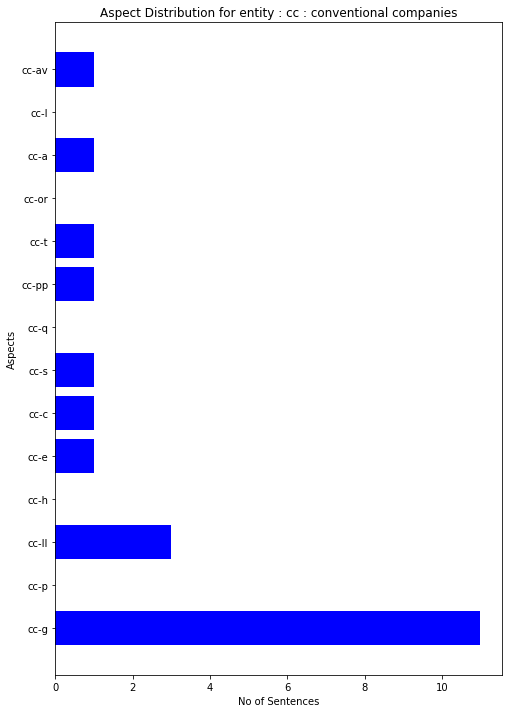

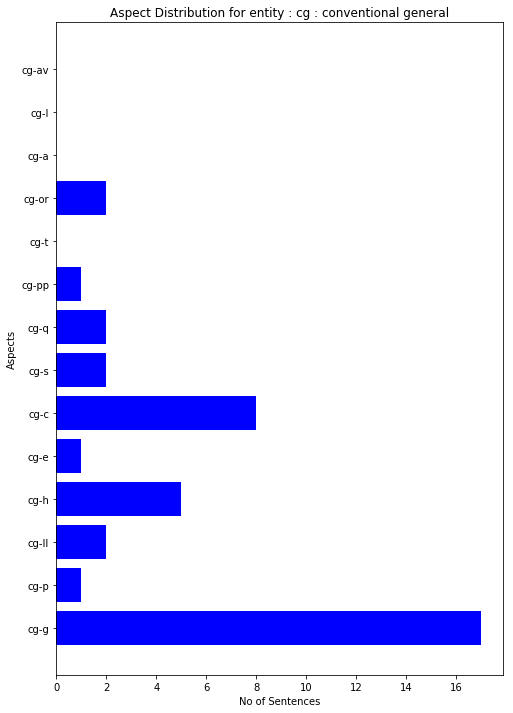

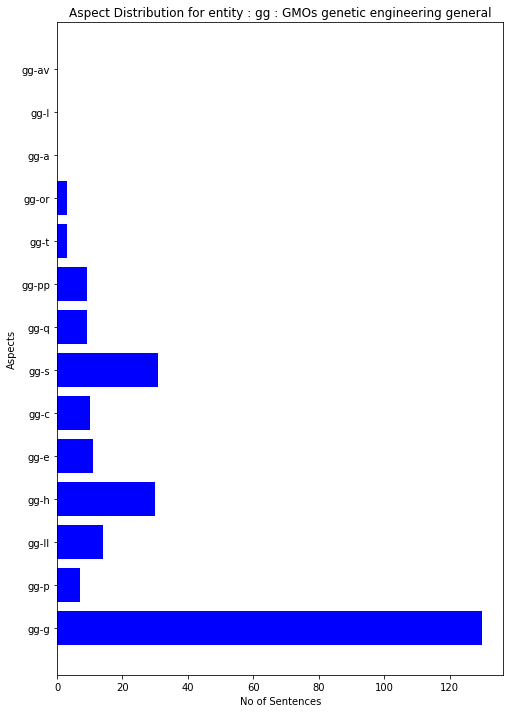

In [19]:
# Train dataset Stats
generate_data_stats(dfTrain)

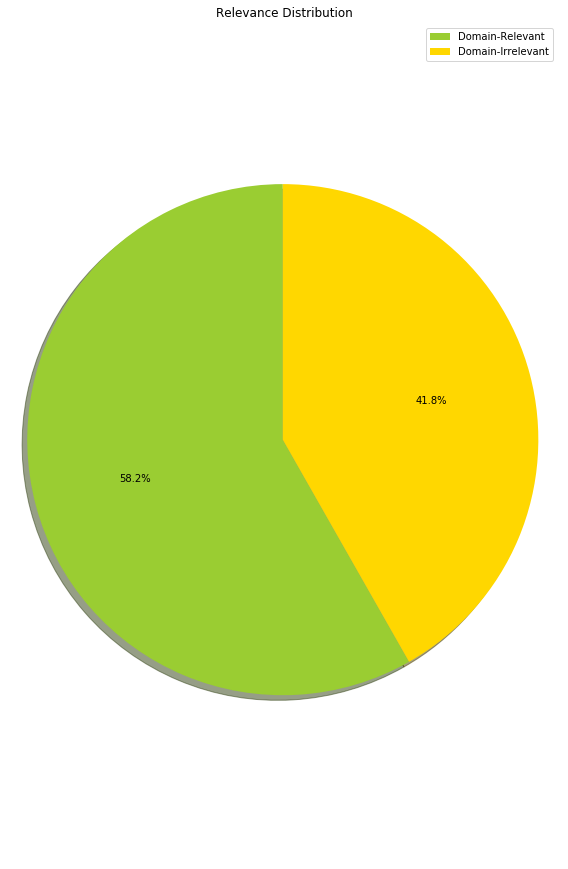

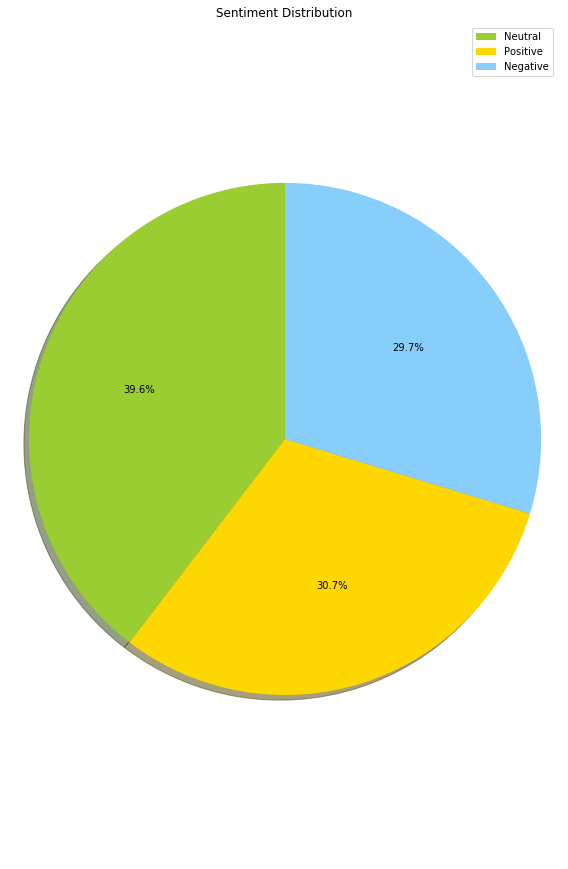

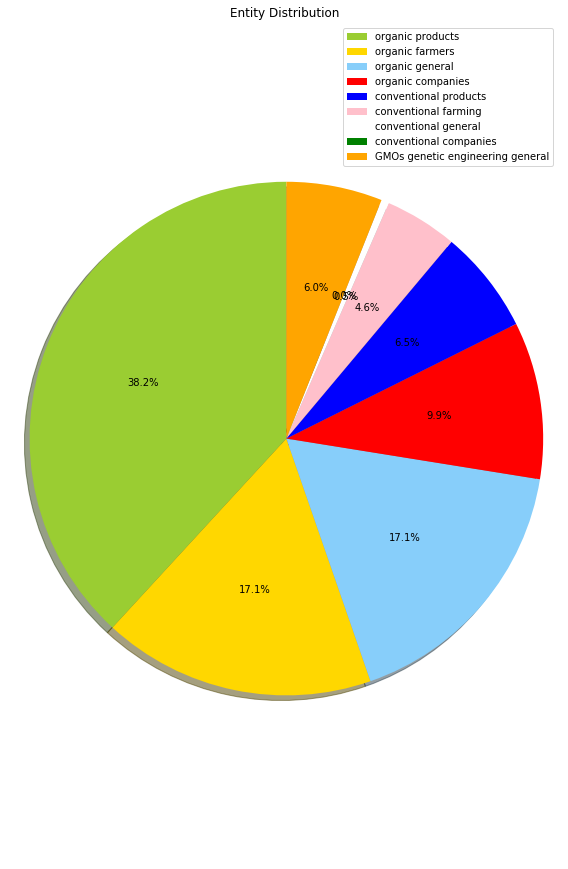

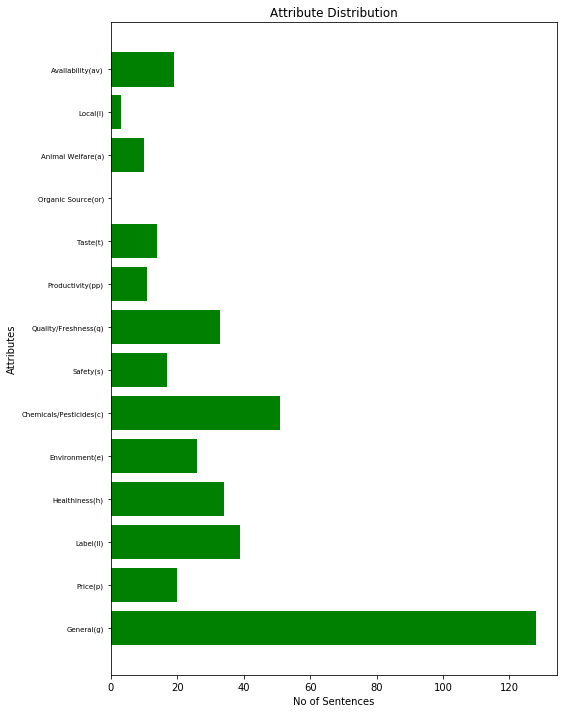

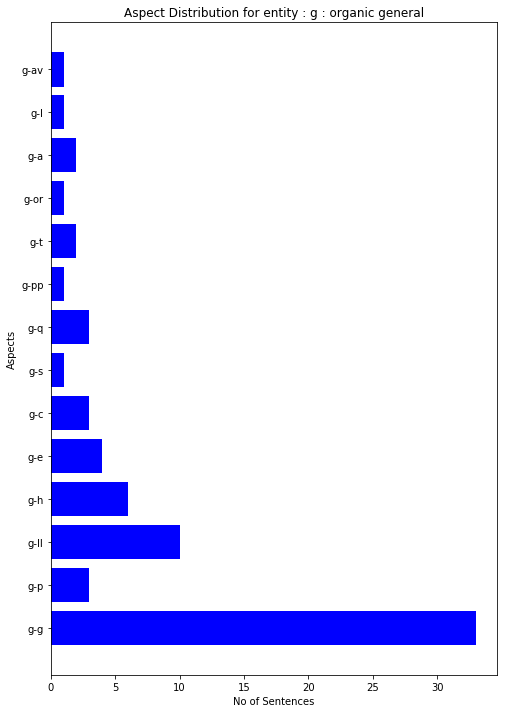

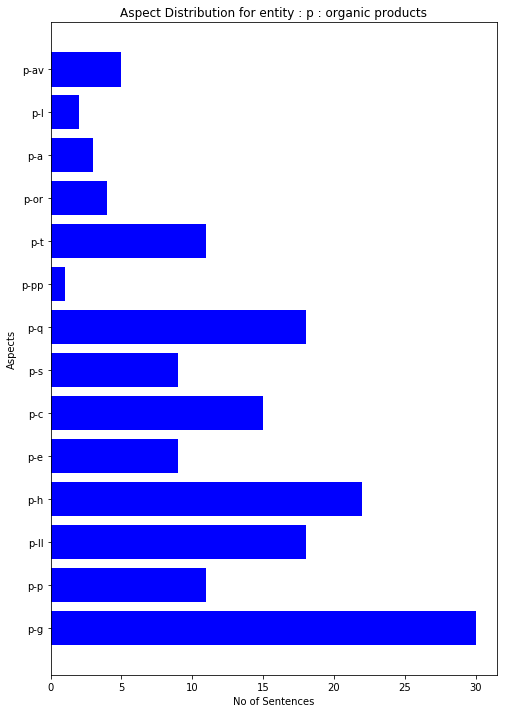

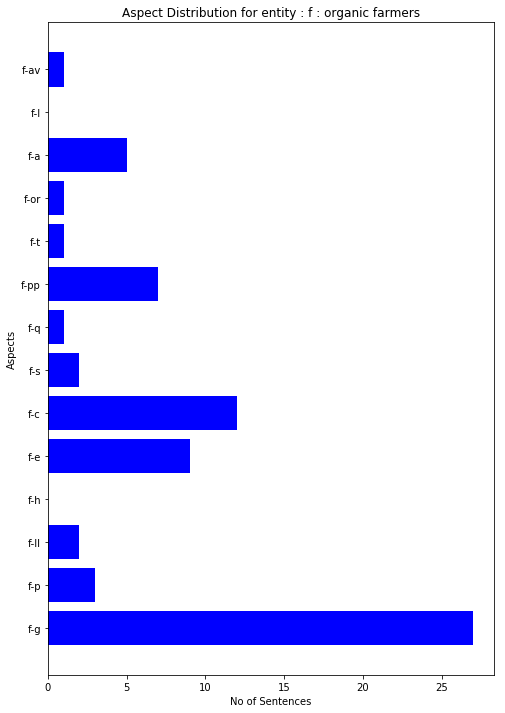

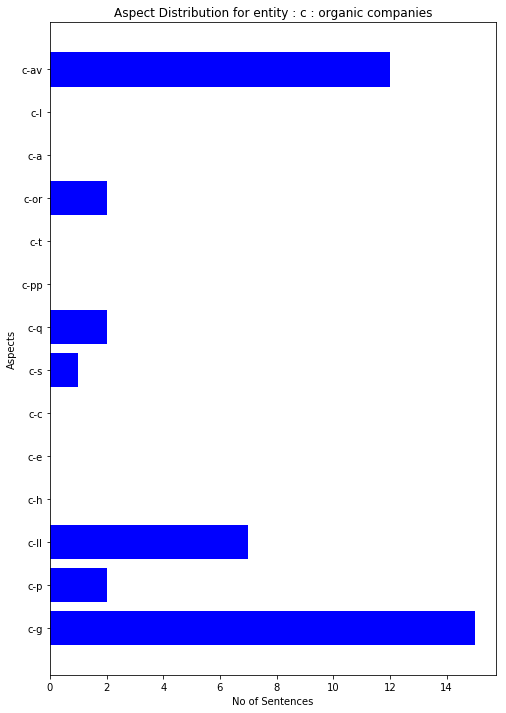

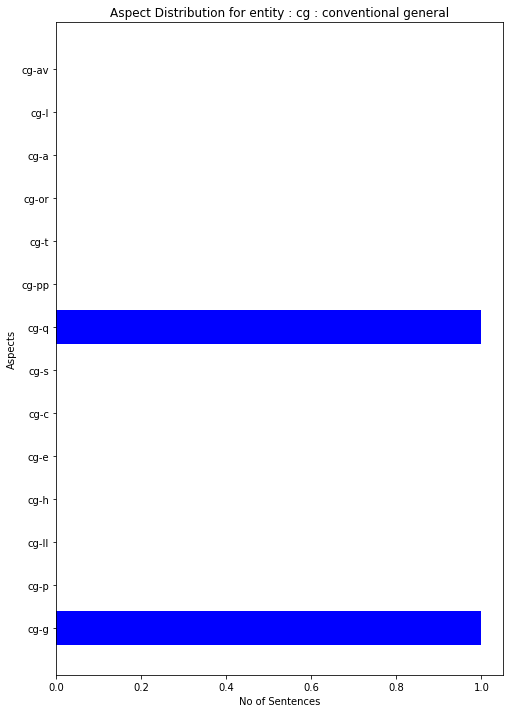

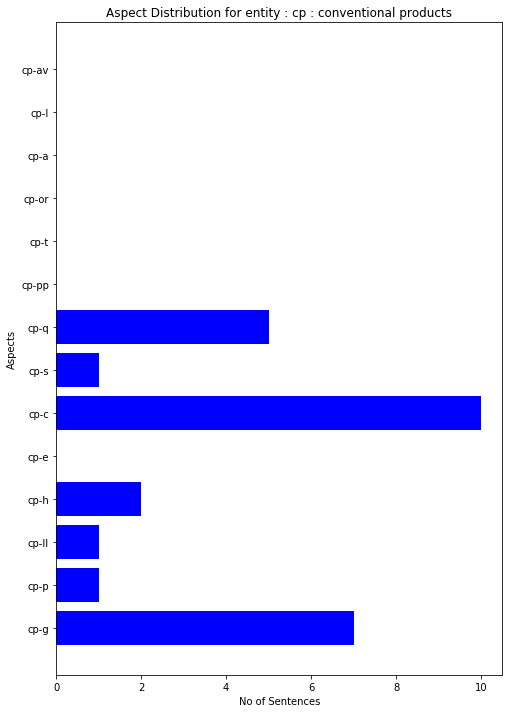

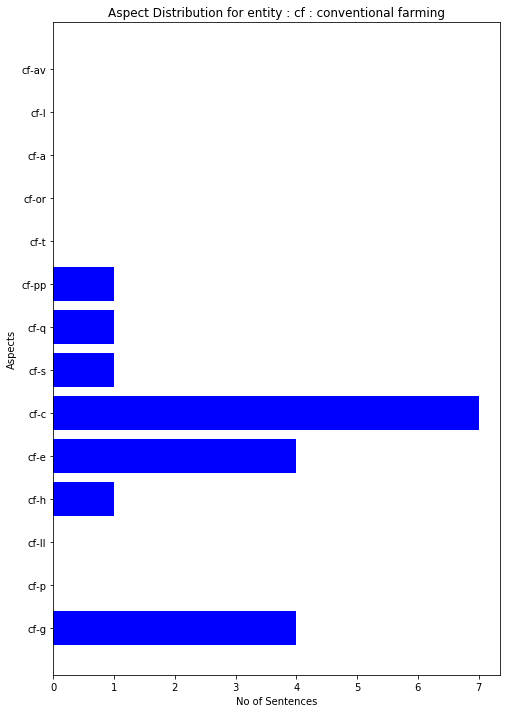

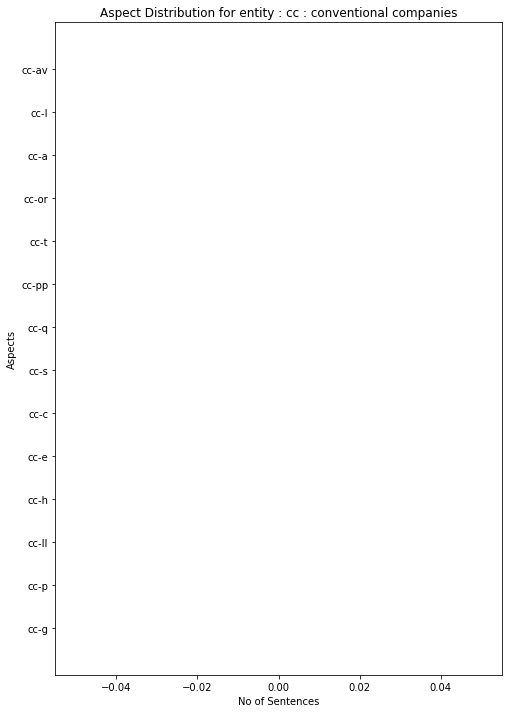

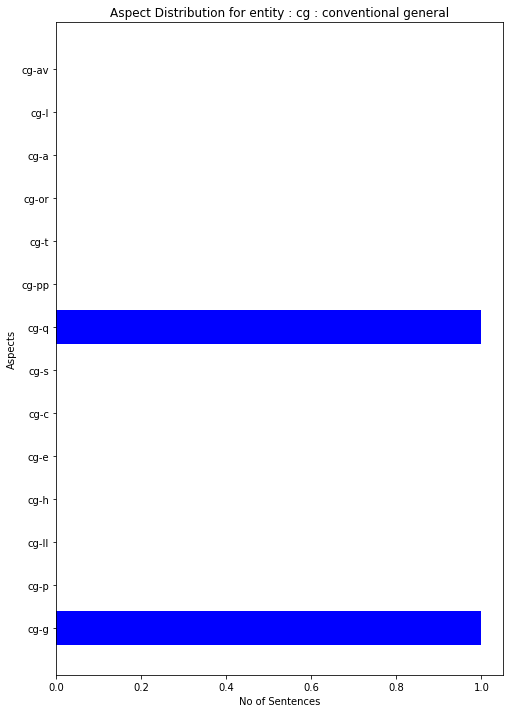

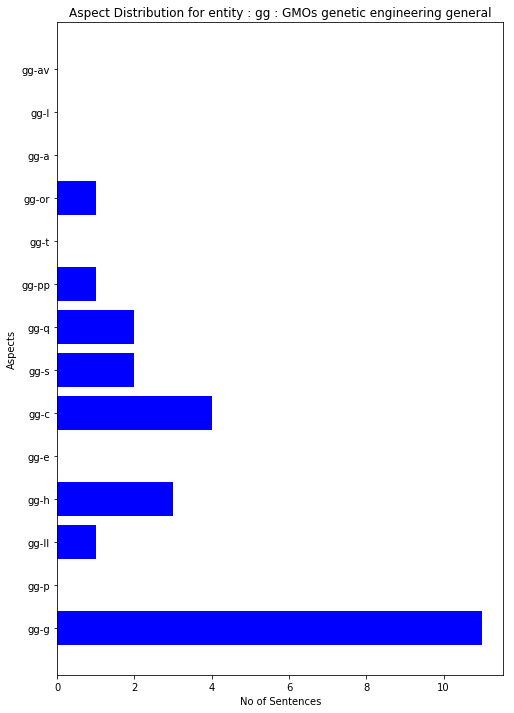

In [20]:
# Validation dataset Stats
generate_data_stats(dfVal)

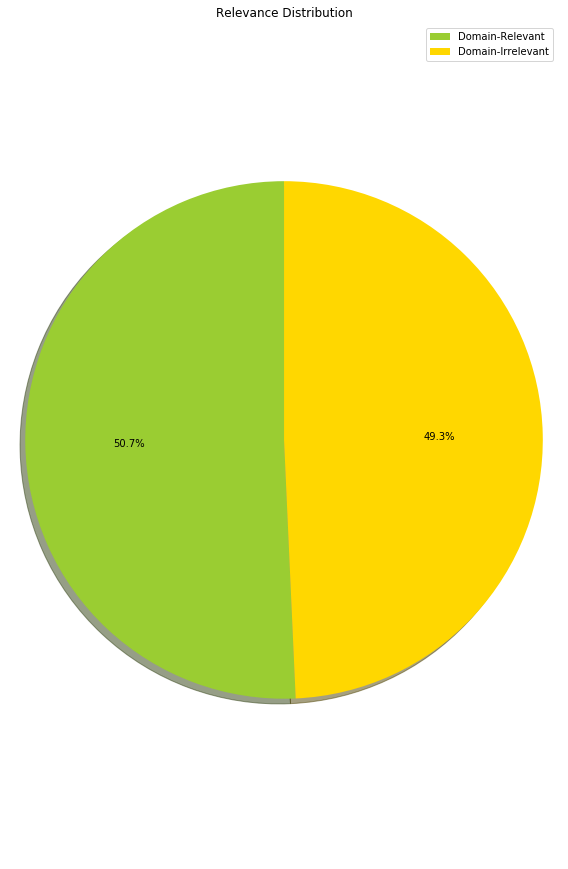

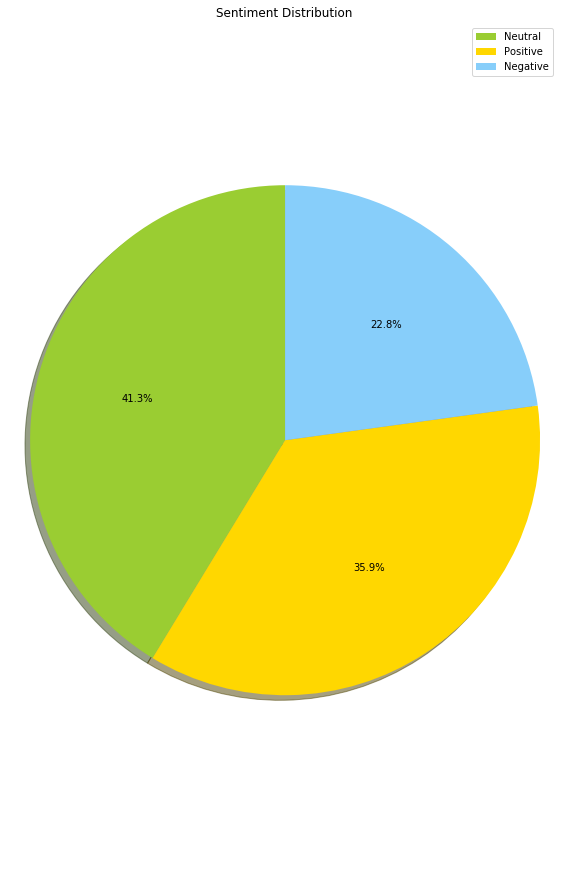

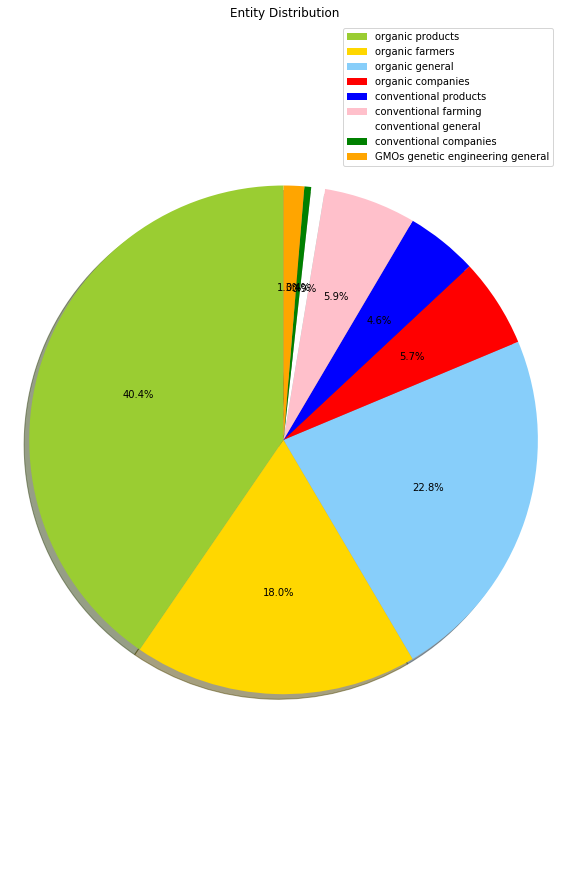

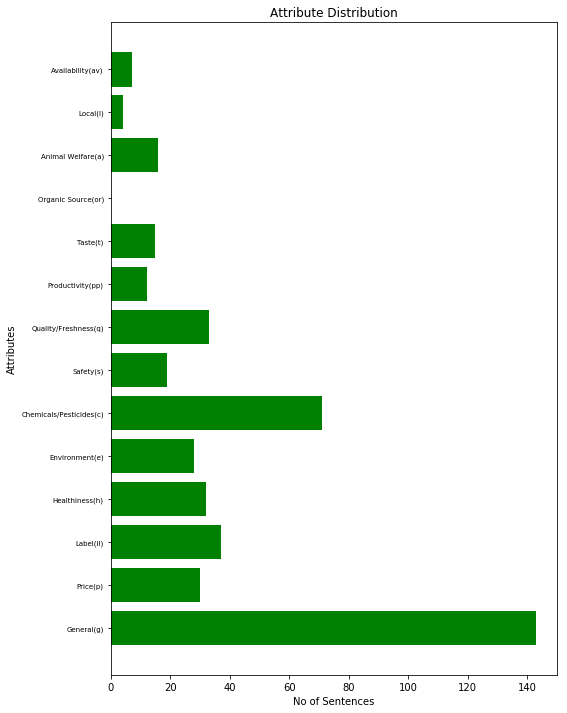

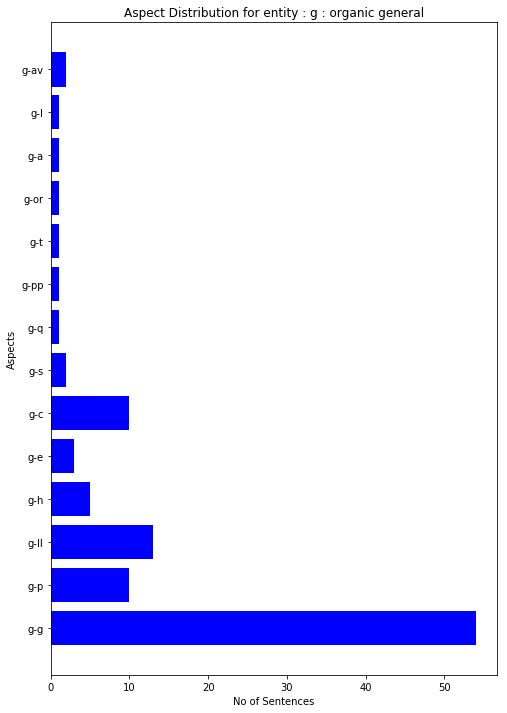

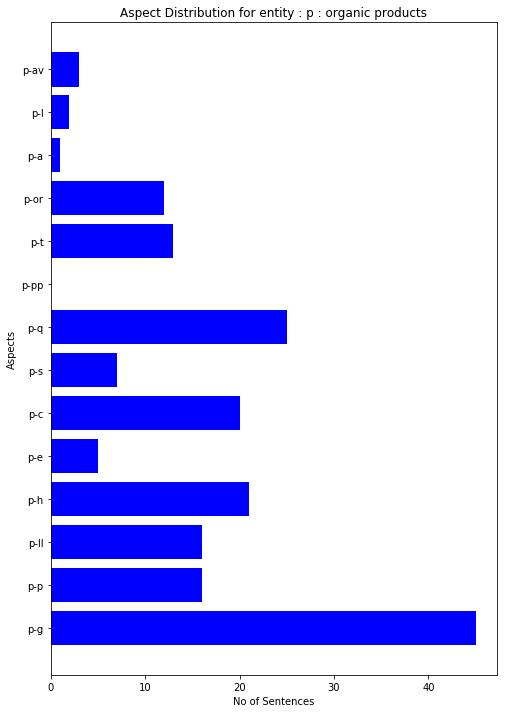

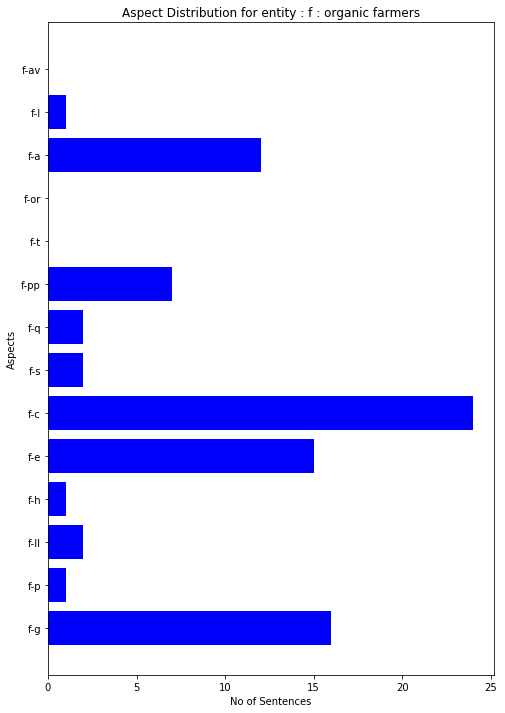

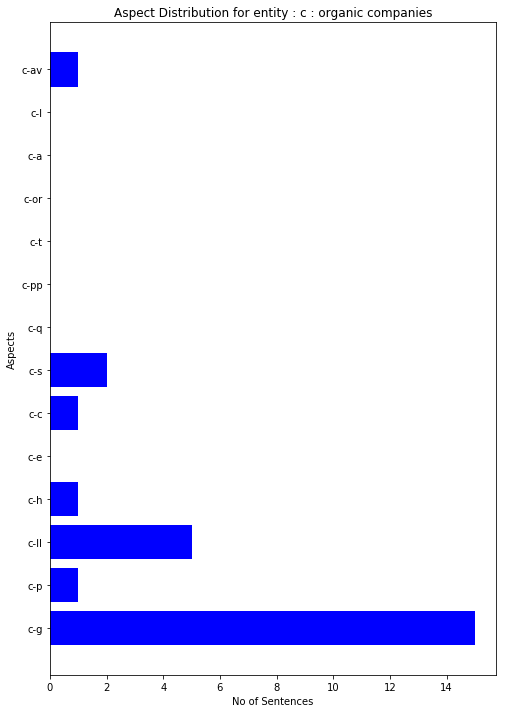

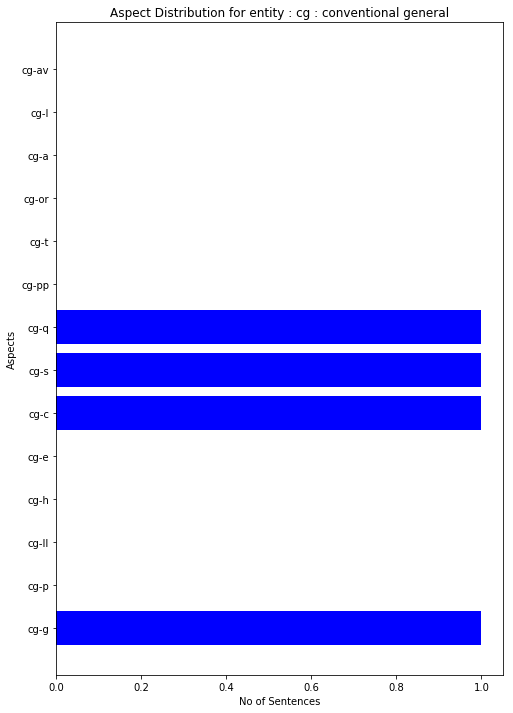

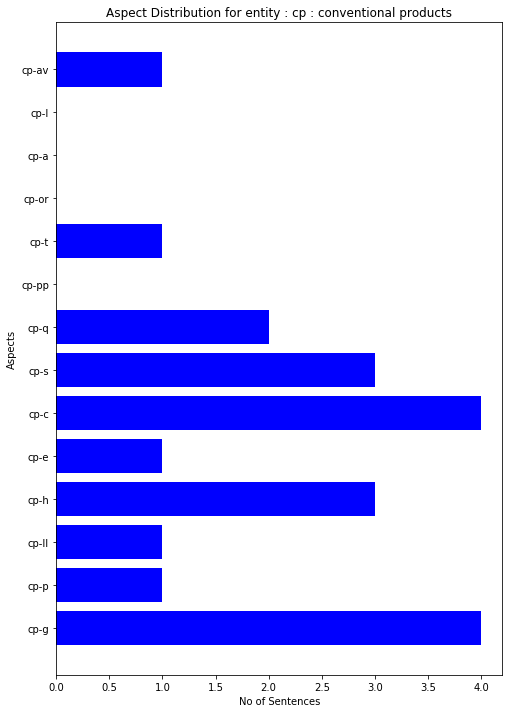

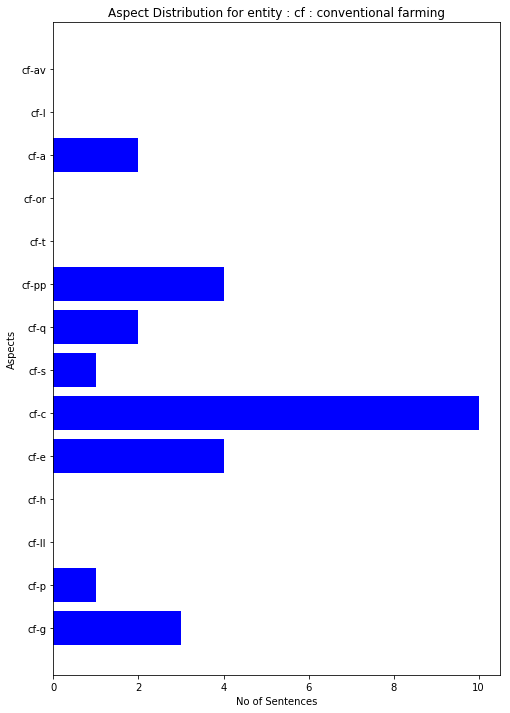

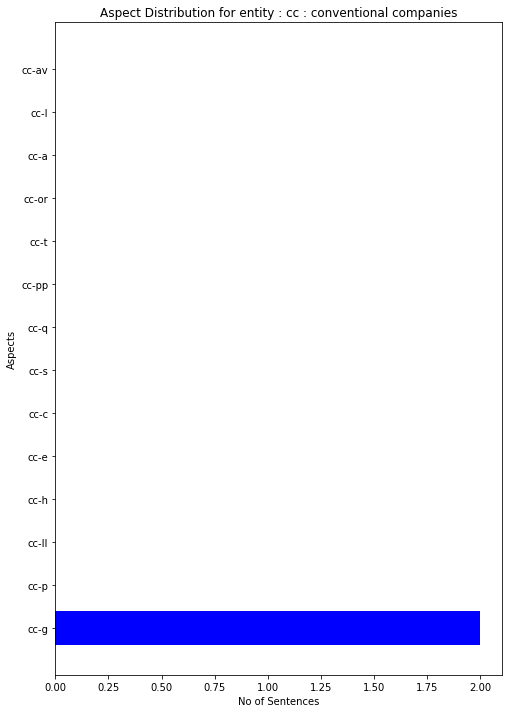

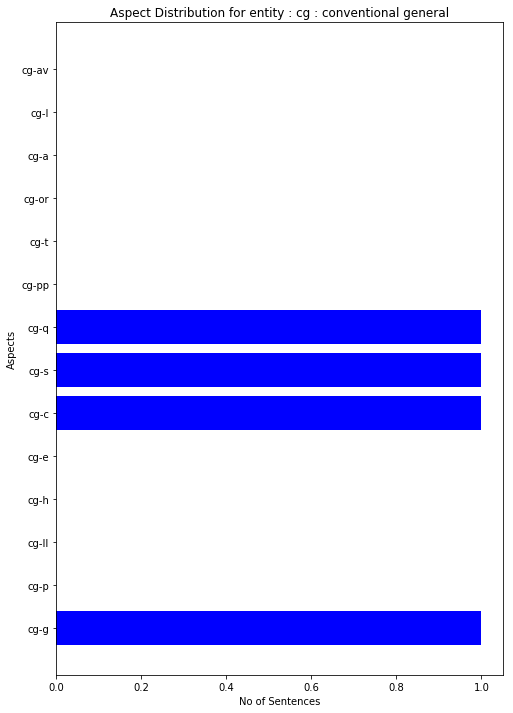

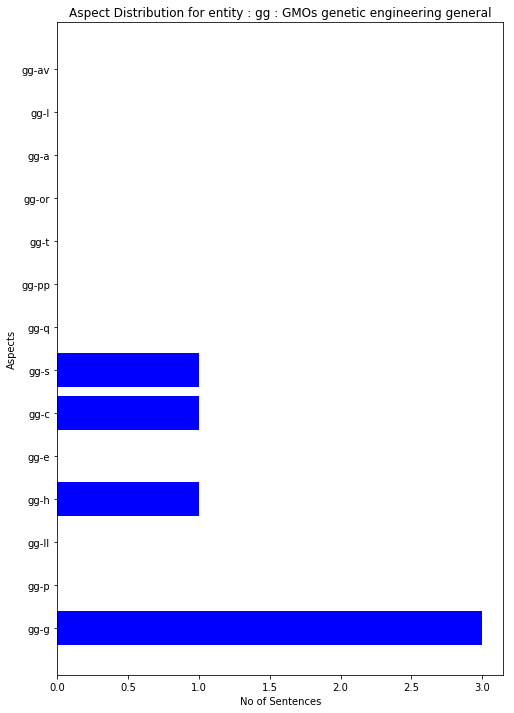

In [21]:
# Test dataset Stats
generate_data_stats(dfTest)